In [1]:
import os, json, math, shutil
import numpy as np
import tensorflow as tf
# environment variables used by bash cells
PROJECT=!(gcloud config get-value project)
PROJECT=PROJECT[0]
REGION = 'us-west1'
BUCKET='{}-dsongcp'.format(PROJECT)
os.environ['ENDPOINT_NAME'] = 'flights'
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['TF_VERSION']='2-' + tf.__version__[2:3]

In [2]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.flights_train_data AS
SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND 
  f.DIVERTED = False AND
  is_train_day = 'True'

Query complete after 0.01s: 100%|██████████| 4/4 [00:00<00:00, 791.08query/s]                         


""


In [3]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.flights_eval_data AS
SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND 
  f.DIVERTED = False AND
  is_train_day = 'False'

Query complete after 0.00s: 100%|██████████| 4/4 [00:00<00:00, 1693.64query/s]                        


""


In [4]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.flights_all_data AS
SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon,
  IF (is_train_day = 'True',
      IF(ABS(MOD(FARM_FINGERPRINT(CAST(f.FL_DATE AS STRING)), 100)) < 60, 'TRAIN', 'VALIDATE'),
      'TEST') AS data_split
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND 
  f.DIVERTED = False

Query complete after 0.00s: 100%|██████████| 4/4 [00:00<00:00, 1409.97query/s]                        


""


In [5]:
%%bash
PROJECT=$(gcloud config get-value project)
for dataset in "train" "eval" "all"; do
  TABLE=dsongcp.flights_${dataset}_data
  CSV=gs://${BUCKET}/ch9/data/${dataset}.csv
  echo "Exporting ${TABLE} to ${CSV} and deleting table"
  bq --project_id=${PROJECT} extract --destination_format=CSV $TABLE $CSV
  bq --project_id=${PROJECT} rm -f $TABLE
done

Exporting dsongcp.flights_train_data to gs://qwiklabs-gcp-04-b1a1154feeef-dsongcp/ch9/data/train.csv and deleting table
Exporting dsongcp.flights_eval_data to gs://qwiklabs-gcp-04-b1a1154feeef-dsongcp/ch9/data/eval.csv and deleting table
Exporting dsongcp.flights_all_data to gs://qwiklabs-gcp-04-b1a1154feeef-dsongcp/ch9/data/all.csv and deleting table


Waiting on bqjob_r65e1f59b5dec30b4_00000184d209c64d_1 ... (66s) Current status: DONE   
Waiting on bqjob_r1ceab69dd6aff5f1_00000184d20ad955_1 ... (34s) Current status: DONE   
Waiting on bqjob_r6bdab017cad8ee44_00000184d20b71f2_1 ... (85s) Current status: DONE   


In [6]:
!gsutil ls -lh gs://{BUCKET}/ch9/data

445.01 MiB  2022-12-02T08:55:43Z  gs://qwiklabs-gcp-04-b1a1154feeef-dsongcp/ch9/data/all.csv
115.19 MiB  2022-12-02T08:54:21Z  gs://qwiklabs-gcp-04-b1a1154feeef-dsongcp/ch9/data/eval.csv
296.96 MiB  2022-12-02T08:53:43Z  gs://qwiklabs-gcp-04-b1a1154feeef-dsongcp/ch9/data/train.csv
TOTAL: 3 objects, 898801258 bytes (857.16 MiB)


In [7]:
DEVELOP_MODE = True
NUM_EXAMPLES = 5000*1000

In [8]:
training_data_uri = 'gs://{}/ch9/data/train*'.format(BUCKET)
validation_data_uri = 'gs://{}/ch9/data/eval*'.format(BUCKET)

In [9]:
NBUCKETS = 5
NEMBEDS = 3
TRAIN_BATCH_SIZE = 64
DNN_HIDDEN_UNITS = '64,32'

In [10]:
if DEVELOP_MODE:
    train_df = tf.data.experimental.make_csv_dataset(training_data_uri, batch_size=5)
    for n, data in enumerate(train_df):
        numpy_data = {k: v.numpy() for k, v in data.items()}
        print(n, numpy_data)
        if n==1: break

2022-12-02 08:57:46.404106: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-12-02 08:57:46.404160: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-02 08:57:46.404190: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tensorflow): /proc/driver/nvidia/version does not exist
2022-12-02 08:57:46.404699: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0 {'ontime': array([1, 0, 1, 0, 0], dtype=int32), 'dep_delay': array([-4, 60, 10,  0, 86], dtype=int32), 'taxi_out': array([14, 16, 15,  9, 14], dtype=int32), 'distance': array([ 362, 1046, 1046,  539,   95], dtype=int32), 'origin': array([b'OAK', b'FLL', b'FLL', b'OME', b'JNU'], dtype=object), 'dest': array([b'ONT', b'SJU', b'SJU', b'ANC', b'SIT'], dtype=object), 'dep_hour': array([20,  0, 16,  4,  8], dtype=int32), 'is_weekday': array([1, 1, 1, 0, 1], dtype=int32), 'carrier': array([b'WN', b'B6', b'NK', b'AS', b'AS'], dtype=object), 'dep_airport_lat': array([37.72278, 26.0725 , 26.0725 , 64.5125 , 58.35472], dtype=float32), 'dep_airport_lon': array([-122.22139,  -80.15278,  -80.15278, -165.44444, -134.57472],
      dtype=float32), 'arr_airport_lat': array([34.05611 , 18.439444, 18.439444, 61.174168, 57.046944],
      dtype=float32), 'arr_airport_lon': array([-117.60111,  -66.00222,  -66.00222, -149.99806, -135.36111],
      dtype=float32)}
1 {'ontime': array([1, 1, 1, 1, 1], dtype=in

In [11]:
def features_and_labels(features):
  label = features.pop('ontime') 
  return features, label
def read_dataset(pattern, batch_size, mode=tf.estimator.ModeKeys.TRAIN, truncate=None):
  dataset = tf.data.experimental.make_csv_dataset(pattern, batch_size, num_epochs=1)
  dataset = dataset.map(features_and_labels)
  if mode == tf.estimator.ModeKeys.TRAIN:
    dataset = dataset.shuffle(batch_size*10)
    dataset = dataset.repeat()
  dataset = dataset.prefetch(1)
  if truncate is not None:
    dataset = dataset.take(truncate)
  return dataset
if DEVELOP_MODE:
    print("Checking input pipeline")
    one_item = read_dataset(training_data_uri, batch_size=2, truncate=1)
    print(list(one_item)) # should print one batch of 2 items

Checking input pipeline
[(OrderedDict([('dep_delay', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([-6, -8], dtype=int32)>), ('taxi_out', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 8, 18], dtype=int32)>), ('distance', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 68, 945], dtype=int32)>), ('origin', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'STT', b'IND'], dtype=object)>), ('dest', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'SJU', b'RSW'], dtype=object)>), ('dep_hour', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([12,  9], dtype=int32)>), ('is_weekday', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 0], dtype=int32)>), ('carrier', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'B6', b'WN'], dtype=object)>), ('dep_airport_lat', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([18.337223, 39.717224], dtype=float32)>), ('dep_airport_lon', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-64.973335, -86.29472 ], dtype=float32)>), ('arr

In [12]:
import tensorflow as tf
real = {
    colname : tf.feature_column.numeric_column(colname) 
          for colname in 
            (
                'dep_delay,taxi_out,distance,dep_hour,is_weekday,' +
                'dep_airport_lat,dep_airport_lon,' +
                'arr_airport_lat,arr_airport_lon'
            ).split(',')
}
sparse = {
      'carrier': tf.feature_column.categorical_column_with_vocabulary_list('carrier',
                  vocabulary_list='AS,VX,F9,UA,US,WN,HA,EV,MQ,DL,OO,B6,NK,AA'.split(',')),
      'origin' : tf.feature_column.categorical_column_with_hash_bucket('origin', hash_bucket_size=1000),
      'dest'   : tf.feature_column.categorical_column_with_hash_bucket('dest', hash_bucket_size=1000),
}

In [13]:
inputs = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32') 
          for colname in real.keys()
}
inputs.update({
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string') 
          for colname in sparse.keys()
})

In [14]:
latbuckets = np.linspace(20.0, 50.0, NBUCKETS).tolist()  # USA
lonbuckets = np.linspace(-120.0, -70.0, NBUCKETS).tolist() # USA
disc = {}
disc.update({
       'd_{}'.format(key) : tf.feature_column.bucketized_column(real[key], latbuckets) 
          for key in ['dep_airport_lat', 'arr_airport_lat']
})
disc.update({
       'd_{}'.format(key) : tf.feature_column.bucketized_column(real[key], lonbuckets) 
          for key in ['dep_airport_lon', 'arr_airport_lon']
})
# cross columns that make sense in combination
sparse['dep_loc'] = tf.feature_column.crossed_column(
    [disc['d_dep_airport_lat'], disc['d_dep_airport_lon']], NBUCKETS*NBUCKETS)
sparse['arr_loc'] = tf.feature_column.crossed_column(
    [disc['d_arr_airport_lat'], disc['d_arr_airport_lon']], NBUCKETS*NBUCKETS)
sparse['dep_arr'] = tf.feature_column.crossed_column([sparse['dep_loc'], sparse['arr_loc']], NBUCKETS ** 4)
# embed all the sparse columns
embed = {
       'embed_{}'.format(colname) : tf.feature_column.embedding_column(col, NEMBEDS)
          for colname, col in sparse.items()
}
real.update(embed)
# one-hot encode the sparse columns
sparse = {
    colname : tf.feature_column.indicator_column(col)
          for colname, col in sparse.items()
}
if DEVELOP_MODE:
    print(sparse.keys())
    print(real.keys())

dict_keys(['carrier', 'origin', 'dest', 'dep_loc', 'arr_loc', 'dep_arr'])
dict_keys(['dep_delay', 'taxi_out', 'distance', 'dep_hour', 'is_weekday', 'dep_airport_lat', 'dep_airport_lon', 'arr_airport_lat', 'arr_airport_lon', 'embed_carrier', 'embed_origin', 'embed_dest', 'embed_dep_loc', 'embed_arr_loc', 'embed_dep_arr'])


In [15]:
output_dir='gs://{}/ch9/trained_model'.format(BUCKET)
os.environ['OUTDIR'] = output_dir  # needed for deployment
print('Writing trained model to {}'.format(output_dir))

Writing trained model to gs://qwiklabs-gcp-04-b1a1154feeef-dsongcp/ch9/trained_model


In [16]:
!gsutil -m rm -rf $OUTDIR

CommandException: 1 files/objects could not be removed.


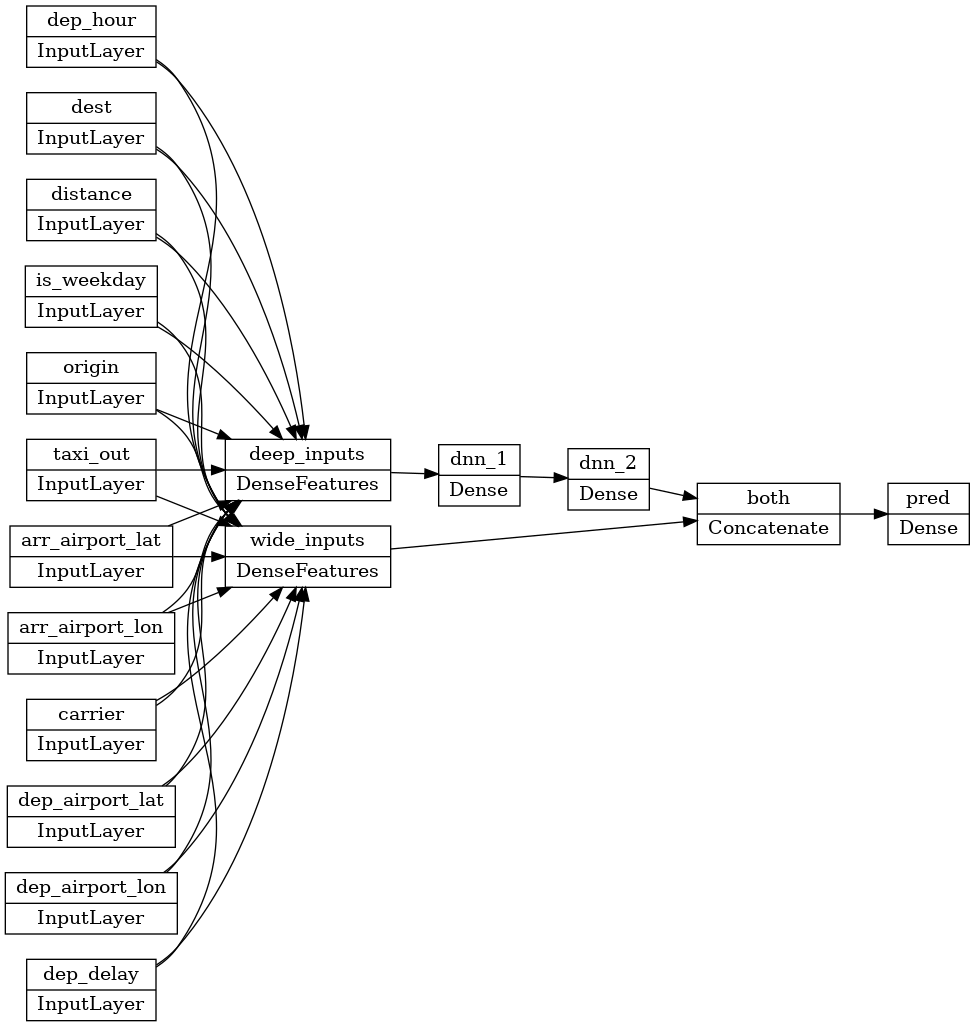

In [17]:
# Build a wide-and-deep model.
def wide_and_deep_classifier(inputs, linear_feature_columns, dnn_feature_columns, dnn_hidden_units):
    deep = tf.keras.layers.DenseFeatures(dnn_feature_columns, name='deep_inputs')(inputs)
    layers = [int(x) for x in dnn_hidden_units.split(',')]
    for layerno, numnodes in enumerate(layers):
        deep = tf.keras.layers.Dense(numnodes, activation='relu', name='dnn_{}'.format(layerno+1))(deep)        
    wide = tf.keras.layers.DenseFeatures(linear_feature_columns, name='wide_inputs')(inputs)
    both = tf.keras.layers.concatenate([deep, wide], name='both')
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='pred')(both)
    model = tf.keras.Model(inputs, output)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
    
model = wide_and_deep_classifier(
    inputs,
    linear_feature_columns = sparse.values(),
    dnn_feature_columns = real.values(),
    dnn_hidden_units = DNN_HIDDEN_UNITS)
tf.keras.utils.plot_model(model, 'flights_model.png', show_shapes=False, rankdir='LR')

In [18]:
# training and evaluation dataset
train_batch_size = TRAIN_BATCH_SIZE
if DEVELOP_MODE:
    eval_batch_size = 100
    steps_per_epoch = 3
    epochs = 2
    num_eval_examples = eval_batch_size*10
else:
    eval_batch_size = 100
    steps_per_epoch = NUM_EXAMPLES // train_batch_size
    epochs = 10
    num_eval_examples = eval_batch_size * 100
train_dataset = read_dataset(training_data_uri, train_batch_size)
eval_dataset = read_dataset(validation_data_uri, eval_batch_size, tf.estimator.ModeKeys.EVAL, num_eval_examples)
checkpoint_path = '{}/checkpoints/flights.cpt'.format(output_dir)
shutil.rmtree(checkpoint_path, ignore_errors=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(train_dataset, 
                    validation_data=eval_dataset,
                    epochs=epochs, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[cp_callback])

Epoch 1/2
1/3 [=========>....................] - ETA: 9s - loss: 1.8866 - accuracy: 0.2031
Epoch 1: saving model to gs://qwiklabs-gcp-04-b1a1154feeef-dsongcp/ch9/trained_model/checkpoints/flights.cpt
3/3 [==============================] - 19s 7s/step - loss: 1.0985 - accuracy: 0.6146 - val_loss: 1.0834 - val_accuracy: 0.8191
Epoch 2/2
1/3 [=========>....................] - ETA: 0s - loss: 0.8692 - accuracy: 0.7969
Epoch 2: saving model to gs://qwiklabs-gcp-04-b1a1154feeef-dsongcp/ch9/trained_model/checkpoints/flights.cpt
3/3 [==============================] - 9s 4s/step - loss: 1.0227 - accuracy: 0.7969 - val_loss: 1.2314 - val_accuracy: 0.8189


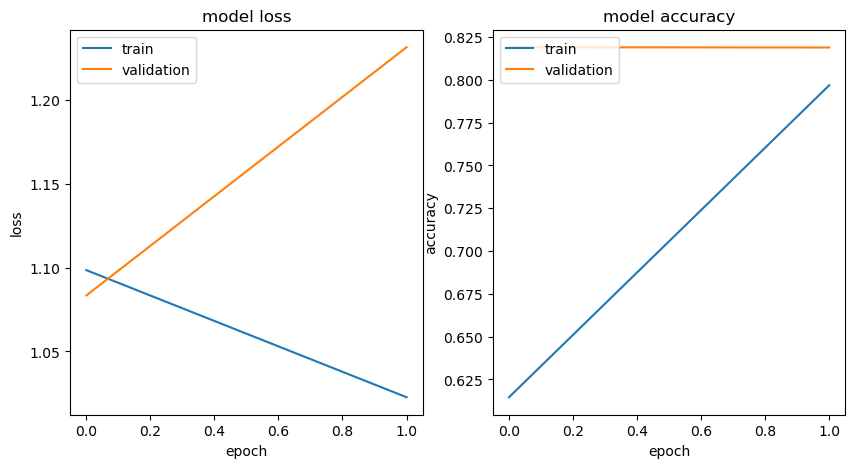

In [19]:
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))
for idx, key in enumerate(['loss', 'accuracy']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

In [20]:
import time
export_dir = '{}/export/flights_{}'.format(output_dir, time.strftime("%Y%m%d-%H%M%S"))
print('Exporting to {}'.format(export_dir))
tf.saved_model.save(model, export_dir)

Exporting to gs://qwiklabs-gcp-04-b1a1154feeef-dsongcp/ch9/trained_model/export/flights_20221202-090258


2022-12-02 09:03:02.045691: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: gs://qwiklabs-gcp-04-b1a1154feeef-dsongcp/ch9/trained_model/export/flights_20221202-090258/assets


In [21]:
%%bash
# note TF_VERSION and ENDPOINT_NAME set in 1st cell
# TF_VERSION=2-6
# ENDPOINT_NAME=flights
TIMESTAMP=$(date +%Y%m%d-%H%M%S)
MODEL_NAME=${ENDPOINT_NAME}-${TIMESTAMP}
EXPORT_PATH=$(gsutil ls ${OUTDIR}/export | tail -1)
echo $EXPORT_PATH
# create the model endpoint for deploying the model
if [[ $(gcloud beta ai endpoints list --region=$REGION \
        --format='value(DISPLAY_NAME)' --filter=display_name=${ENDPOINT_NAME}) ]]; then
    echo "Endpoint for $MODEL_NAME already exists"
else
    echo "Creating Endpoint for $MODEL_NAME"
    gcloud beta ai endpoints create --region=${REGION} --display-name=${ENDPOINT_NAME}
fi
ENDPOINT_ID=$(gcloud beta ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo "ENDPOINT_ID=$ENDPOINT_ID"
# delete any existing models with this name
for MODEL_ID in $(gcloud beta ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME}); do
    echo "Deleting existing $MODEL_NAME ... $MODEL_ID "
    gcloud ai models delete --region=$REGION $MODEL_ID
done
# create the model using the parameters docker conatiner image and artifact uri
gcloud beta ai models upload --region=$REGION --display-name=$MODEL_NAME \
     --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.${TF_VERSION}:latest \
     --artifact-uri=$EXPORT_PATH
MODEL_ID=$(gcloud beta ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME})
echo "MODEL_ID=$MODEL_ID"
# deploy the model to the endpoint
gcloud beta ai endpoints deploy-model $ENDPOINT_ID \
  --region=$REGION \
  --model=$MODEL_ID \
  --display-name=$MODEL_NAME \
  --machine-type=n1-standard-2 \
  --min-replica-count=1 \
  --max-replica-count=1 \
  --traffic-split=0=100

gs://qwiklabs-gcp-04-b1a1154feeef-dsongcp/ch9/trained_model/export/flights_20221202-090258/
Creating Endpoint for flights-20221202-090429
ENDPOINT_ID=730797000471085056
MODEL_ID=1444195328944242688


Using endpoint [https://us-west1-aiplatform.googleapis.com/]
Using endpoint [https://us-west1-aiplatform.googleapis.com/]
Waiting for operation [5587218914078621696]...
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................done.
Created Vertex AI endpoint: projects/844935702522/locations/us-west1/endpoints/7

In [22]:
%%writefile example_input.json
{"instances": [
  {"dep_hour": 2, "is_weekday": 1, "dep_delay": 40, "taxi_out": 17, "distance": 41, "carrier": "AS", "dep_airport_lat": 58.42527778, "dep_airport_lon": -135.7075, "arr_airport_lat": 58.35472222, "arr_airport_lon": -134.57472222, "origin": "GST", "dest": "JNU"},
  {"dep_hour": 22, "is_weekday": 0, "dep_delay": -7, "taxi_out": 7, "distance": 201, "carrier": "HA", "dep_airport_lat": 21.97611111, "dep_airport_lon": -159.33888889, "arr_airport_lat": 20.89861111, "arr_airport_lon": -156.43055556, "origin": "LIH", "dest": "OGG"}
]}

Writing example_input.json


In [23]:
%%bash
ENDPOINT_ID=$(gcloud beta ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo $ENDPOINT_ID
gcloud beta ai endpoints predict $ENDPOINT_ID --region=$REGION --json-request=example_input.json

730797000471085056
[[0.910529494], [0.924933791]]


Using endpoint [https://us-west1-aiplatform.googleapis.com/]
Using endpoint [https://us-west1-prediction-aiplatform.googleapis.com/]


In [24]:
%%bash
PROJECT=$(gcloud config get-value project)
ENDPOINT_ID=$(gcloud beta ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
curl -X POST \
  -H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
  -H "Content-Type: application/json; charset=utf-8" \
  -d @example_input.json \
  "https://${REGION}-aiplatform.googleapis.com/v1/projects/${PROJECT}/locations/${REGION}/endpoints/${ENDPOINT_ID}:predict"

{
  "predictions": [
    [
      0.910529494
    ],
    [
      0.924933791
    ]
  ],
  "deployedModelId": "1233370571387961344",
  "model": "projects/844935702522/locations/us-west1/models/1444195328944242688",
  "modelDisplayName": "flights-20221202-090429",
  "modelVersionId": "1"
}


Using endpoint [https://us-west1-aiplatform.googleapis.com/]
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   831    0   288  100   543   3645   6873 --:--:-- --:--:-- --:--:-- 10518


In [25]:
%%bash
model_dir=$(gsutil ls ${OUTDIR}/export | tail -1)
echo $model_dir
saved_model_cli show --tag_set serve --signature_def serving_default --dir $model_dir

gs://qwiklabs-gcp-04-b1a1154feeef-dsongcp/ch9/trained_model/export/flights_20221202-090258/
The given SavedModel SignatureDef contains the following input(s):
  inputs['arr_airport_lat'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_arr_airport_lat:0
  inputs['arr_airport_lon'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_arr_airport_lon:0
  inputs['carrier'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_carrier:0
  inputs['dep_airport_lat'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_airport_lat:0
  inputs['dep_airport_lon'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_airport_lon:0
  inputs['dep_delay'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_delay:0
  inputs['dep_hour'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_

In [26]:
cols = ('dep_delay,taxi_out,distance,dep_hour,is_weekday,' +
        'dep_airport_lat,dep_airport_lon,' +
        'arr_airport_lat,arr_airport_lon,' +
        'carrier,origin,dest')
inputs = {x: {"inputTensorName": "{}".format(x)} 
        for x in cols.split(',')}
expl = {
    "inputs": inputs,
    "outputs": {
    "pred": {
      "outputTensorName": "pred"
    }
  }
}
print(expl)
with open('explanation-metadata.json', 'w') as ofp:
    json.dump(expl, ofp, indent=2)

{'inputs': {'dep_delay': {'inputTensorName': 'dep_delay'}, 'taxi_out': {'inputTensorName': 'taxi_out'}, 'distance': {'inputTensorName': 'distance'}, 'dep_hour': {'inputTensorName': 'dep_hour'}, 'is_weekday': {'inputTensorName': 'is_weekday'}, 'dep_airport_lat': {'inputTensorName': 'dep_airport_lat'}, 'dep_airport_lon': {'inputTensorName': 'dep_airport_lon'}, 'arr_airport_lat': {'inputTensorName': 'arr_airport_lat'}, 'arr_airport_lon': {'inputTensorName': 'arr_airport_lon'}, 'carrier': {'inputTensorName': 'carrier'}, 'origin': {'inputTensorName': 'origin'}, 'dest': {'inputTensorName': 'dest'}}, 'outputs': {'pred': {'outputTensorName': 'pred'}}}


In [27]:
%%bash
# note TF_VERSION set in 1st cell, but ENDPOINT_NAME is being changed
# TF_VERSION=2-6
ENDPOINT_NAME=flights_xai
TIMESTAMP=$(date +%Y%m%d-%H%M%S)
MODEL_NAME=${ENDPOINT_NAME}-${TIMESTAMP}
EXPORT_PATH=$(gsutil ls ${OUTDIR}/export | tail -1)
echo $EXPORT_PATH
# create the model endpoint for deploying the model
if [[ $(gcloud beta ai endpoints list --region=$REGION \
        --format='value(DISPLAY_NAME)' --filter=display_name=${ENDPOINT_NAME}) ]]; then
    echo "Endpoint for $MODEL_NAME already exists"
else
    # create model endpoint
    echo "Creating Endpoint for $MODEL_NAME"
    gcloud beta ai endpoints create --region=${REGION} --display-name=${ENDPOINT_NAME}
fi
ENDPOINT_ID=$(gcloud beta ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo "ENDPOINT_ID=$ENDPOINT_ID"
# delete any existing models with this name
for MODEL_ID in $(gcloud beta ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME}); do
    echo "Deleting existing $MODEL_NAME ... $MODEL_ID "
    gcloud ai models delete --region=$REGION $MODEL_ID
done
# upload the model using the parameters docker conatiner image, artifact URI, explanation method, 
# explanation path count and explanation metadata JSON file `explanation-metadata.json`. 
# Here, you keep number of feature permutations to `10` when approximating the Shapley values for explanation.
gcloud beta ai models upload --region=$REGION --display-name=$MODEL_NAME \
     --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.${TF_VERSION}:latest \
     --artifact-uri=$EXPORT_PATH \
     --explanation-method=sampled-shapley --explanation-path-count=10 --explanation-metadata-file=explanation-metadata.json
MODEL_ID=$(gcloud beta ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME})
echo "MODEL_ID=$MODEL_ID"
# deploy the model to the endpoint
gcloud beta ai endpoints deploy-model $ENDPOINT_ID \
  --region=$REGION \
  --model=$MODEL_ID \
  --display-name=$MODEL_NAME \
  --machine-type=n1-standard-2 \
  --min-replica-count=1 \
  --max-replica-count=1 \
  --traffic-split=0=100

gs://qwiklabs-gcp-04-b1a1154feeef-dsongcp/ch9/trained_model/export/flights_20221202-090258/
Creating Endpoint for flights_xai-20221202-092544
ENDPOINT_ID=8590704250139443200
MODEL_ID=2861703311659106304


Using endpoint [https://us-west1-aiplatform.googleapis.com/]
Using endpoint [https://us-west1-aiplatform.googleapis.com/]
Waiting for operation [6677090023902281728]...
...................done.
Created Vertex AI endpoint: projects/844935702522/locations/us-west1/endpoints/8590704250139443200.
Using endpoint [https://us-west1-aiplatform.googleapis.com/]
Using endpoint [https://us-west1-aiplatform.googleapis.com/]
Using endpoint [https://us-west1-aiplatform.googleapis.com/]
Waiting for operation [7893061923292315648]...
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [28]:
%%bash
PROJECT=$(gcloud config get-value project)
ENDPOINT_NAME=flights_xai
ENDPOINT_ID=$(gcloud beta ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
curl -X POST \
  -H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
  -H "Content-Type: application/json; charset=utf-8" \
  -d @example_input.json \
  "https://${REGION}-aiplatform.googleapis.com/v1/projects/${PROJECT}/locations/${REGION}/endpoints/${ENDPOINT_ID}:explain"

{
  "explanations": [
    {
      "attributions": [
        {
          "baselineOutputValue": 0.51510369777679443,
          "instanceOutputValue": 0.9105294942855835,
          "featureAttributions": {
            "arr_airport_lon": 0.01072768568992615,
            "dep_hour": 0.0037108361721038818,
            "arr_airport_lat": 0.085352137684822083,
            "is_weekday": -0.000821375846862793,
            "dep_airport_lat": 0.091873100399971014,
            "taxi_out": 0.026857209205627439,
            "carrier": -0.00567159652709961,
            "dep_airport_lon": 0.22567392587661739,
            "origin": -0.005807924270629883,
            "dep_delay": -0.1081736147403717,
            "dest": -0.0067981958389282228,
            "distance": 0.078503608703613281
          },
          "outputIndex": [
            0
          ],
          "approximationError": 0.0079310235810276034,
          "outputName": "pred"
        }
      ]
    },
    {
      "attributions": [
        {
 

Using endpoint [https://us-west1-aiplatform.googleapis.com/]
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2550    0  2007  100   543    952    257  0:00:02  0:00:02 --:--:--  1209
